# Statistical procedure for the data of the Higgs boson

The following procedure is gathered from the CMS - NOTE 2011-005, and is the statistical approach used to do an hypothesis test to determine wether the results for the Higgs boson mass produced by the data is only created by background or an actual signal in combination with background.

We make the signal and the background functions of the nuiance parameter $\theta$, and denote them $s\left(\theta\right)$ and $b\left(\theta\right)$ respectfully.

1. Construct the likelyhood function
$$\mathcal{L}\left(\mbox{data}|\mu,\theta\right) = \mbox{Poisson}\left(\mbox{data}|\mu \cdot s\left(\theta\right) + b\left(\theta\right)\right)\cdot p\left(\tilde{\theta}|\theta\right)$$

* Data represents either actual experimental observation or pseudo-data used to construct sampling distributions

* $\mu$ is the signal strength modifier and $\theta$ represents the full suite of nuiance parameters

* Poissons(data|$\mu s + b$) stands for a product of Poisson probabilities to observe $n_i$ events in bins $i$:
$$\prod_{i} \frac{\left(\mu s_i + b_i\right)^{n_i}}{n_i !} e^{-\mu s_i - b_i}$$

2. To compare the compability of the data with the background -only and signal + background hypothesis, the test statistic $$\tilde{q_{\mu}} =  - 2ln \frac{\mathcal{L}\left(\mbox{data}|\mu,\hat{\theta_{\mu}}\right)}{\mathcal{L}\left(\mbox{data}|\hat{\mu},\hat{\theta_{\mu}}\right)},$$ with $0 \leq \hat{\mu} \leq \mu$. Where $\hat{\theta_{\mu}}$ refers to the conditional maximum likelyhood estimate of $\theta$, given the signal strength paramter $\mu$ and data. $\hat{\mu}$ and $\hat{\theta}$ correspond to the global maximum of the likelihood.

3. Find the observed value of the test statisitc $\tilde{q_{\mu}^{obs}}$ for the given signal strength modifier $\mu$ under test.

4. Find values of the nuisance paramters $\hat{\theta_{o}^{obs}}$ and $\hat{\theta}_{\mu}^{\mbox{obs}}$ best describing the experimentally observed data, for the background only and signal + background hypothesis, respectively. 

5. Use (a bit unsure because, in the CMS document it says generate toy monte carlo pseudo-data, but I assume that part is done, so I assume we are just supposed to use the generated one) the generated pseudo-data to construct $pdf$s $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta}_{\mu}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta}_{0}^{obs}\right)$ assuming a signal with strength $\mu$ in the signal + background hypothesis and for the background only hypothesis ($\mu = 0$).

6. Having constructed $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta}_{\mu}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta}_{0}^{obs}\right)$ distributions, define two p-values to be associated with the actual observation for the signal + background and background-only hypothesis, $p_{\mu}$ and $p_b$:
$$p_{\mu} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{signal + background}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|\mu, \hat{\theta}_{\mu}^{obs}\right) d\tilde{q_{\mu}} $$

$$1- p_{b} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{background only}\right) = \int_{\tilde{q}_{+0}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|0, \hat{\theta}_{0}^{obs}\right) d\tilde{q_{\mu}}$$

and calculate $CL_{s}\left(\mu\right) = \frac{p_{\mu}}{1-p_{b}}$.

7. If, for $\mu = 1$, $CL_s \leq \alpha$, we would state that the SM Higgs boson is excluded with (1 - $\alpha$) confidence level.

8. To quote the 95$\%$ Confidence Level upper limit on $\mu$, to be further denoted as $\mu^{95\%CL}$ we adjust $\mu$ until we reach $CL_s = 0.05$.


Further the procedure states that the test statistic used for the higgs boson is $q_{\mu}$ with $\hat{\mu} \geq 0$. (see expression for $q_{\mu}$ above.)

## Imports

In [1]:
# Useful packages
import pandas as pd
import scipy.stats as ss
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy as sp
import pyhf
from   matplotlib.pyplot import figure
from   tqdm import tqdm
import scipy.integrate as integrate
import scipy.special as special
import seaborn as sns
import matplotlib.patches as mpatches

## Uploading data and checking the correspondence between data and simulations

considering only m>100 GeV

In [171]:
sim_signal_counts     = np.load(r'signal_counts.npy')
sim_background_counts = np.load(r'background_counts.npy')
true_counts           = np.load(r'true_counts.npy')
bin_counts            = np.load(r'bins.npy')

Text(0, 0.5, 'Counts')

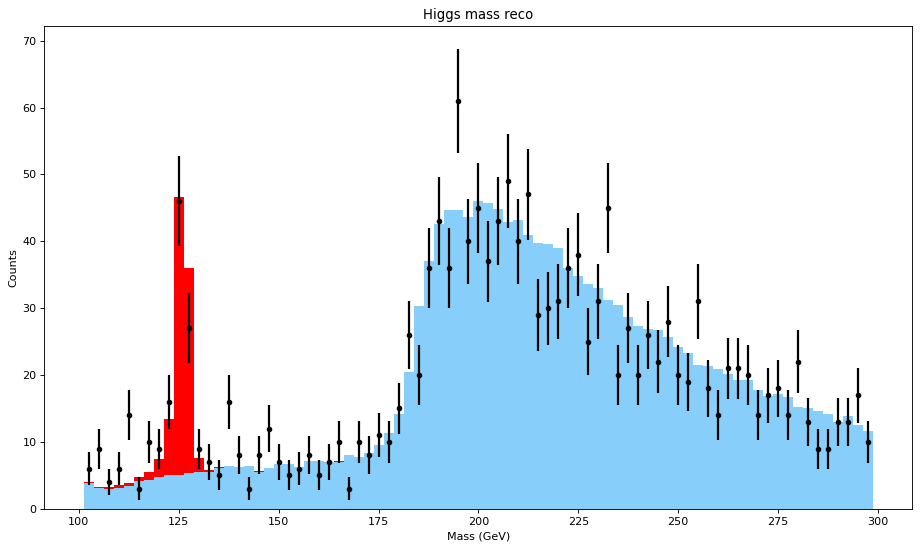

In [533]:
figure(figsize=(14, 8), dpi=80)

width      = [bin_counts[1] - bin_counts[0]]
bincenters = ( bin_counts[1:] + bin_counts[:-1] + width ) / 2

plt.errorbar( bincenters, true_counts,
              yerr   = np.sqrt(true_counts),
              markersize  = 8,
              fmt    = '.', 
              color  = 'black',
              linewidth = 2)
plt.bar(bin_counts[1:,], sim_background_counts + sim_signal_counts , 
        color = 'red', alpha = 1, 
        width = width  )
plt.bar(bin_counts[1:,], sim_background_counts , 
        color = 'lightskyblue', alpha = 1, 
        width = width )
plt.title("Higgs mass reco")
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts")

## Defining necessary functions

In [358]:
# We can assume the data we are getting in is an array of discrete counts;
# The likelihood function for each bin is given by the poisson distribution
# pmf(k, mu, loc=0)

# log of likelihood function to avoid underflow

def log_likelihood(mu,s,b,n):
    """ 
    s = number of expected signal events in bin i 
    b = number of expected background events in bin i 
    n = number of real events in bin i 
    """
    nu = mu*s +b
    return sum(np.log(ss.poisson.pmf(n,nu)))



# we construct the test statistic q ̃_mu based on the profile likelihood ratio:

def q_tilde_mu(mu_1, mu_2, s, b, t, func=log_likelihood):
    log_val = func(mu_1,s,b,t) - func(mu_2,s,b,t)
    return -2*log_val 



# Functions for generating toy Monte Carlo pseudo-data to construct pdfs f(q^~_μ |μ) and f (q^ ̃_μ |0 )
# assuming a signal with strength μ in the signal+background hypothesis and for the
# background-only hypothesis (μ = 0). 

def create_toy(mu,s,b):
    """
    return a random Poisson distributed value
    with mu*s + b as its expected value
    """
    return ss.poisson.rvs((mu*s+b),size=1)


def create_toy_distr(mu,s,b,func = create_toy):
    """
    generate for each bin a random Poisson 
    distributed values in according to the 
    counts for simulated signal and background 
    """
    toys_list = np.zeros(len(s))
    for i in range(len(s)):
        toys_list[i] = func(mu,s[i],b[i])
        
    return toys_list


# loop over all the different toy-datasets
# and calculate the optimal mu for each of them
def get_mu_max( df = toy_data_mu_0):
   
    n_toys = len(df.iloc[:,0])
    mu_s   = np.zeros(n_toys)

    for i in tqdm(range(n_toys)):
        
        fun = lambda mu: -log_likelihood(mu,
                                     sim_signal_counts,
                                     sim_background_counts,
                                     df.iloc[i,:])
        mu_opt_i  = sp.optimize.minimize(fun,0.5,bounds=((0,1),))["x"]
        mu_s[i]   = mu_opt_i

    return mu_s


### Finding the q-values of our original data

Finding $\mu$ that maximize the likelihood function in [0,1] is equal to find $\mu$ that minimize the likelihood function.

We used scipy.optimize.minimize to find the minimum of -log.likelihood 

The best fit value of mu for our original data is:  0.957114260308142


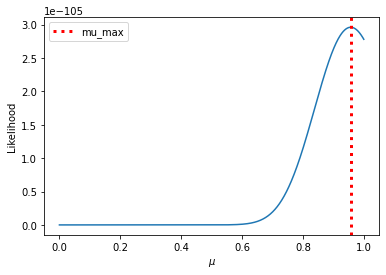

In [333]:
fun    = lambda mu: -log_likelihood(mu, sim_signal_counts[0:,],
                                    sim_background_counts[0:,],
                                    true_counts[0:,])
mu_opt = sp.optimize.minimize(fun,0.5,bounds=((0,1),))
mu_max = mu_opt["x"][0]
print("The best fit value of mu for our original data is: ",mu_max)

mu = np.linspace(0, 1, 3001)
likelihood_val = []
for i in mu:
    x = log_likelihood(i, sim_signal_counts[0:,], 
                          sim_background_counts[0:,], 
                          true_counts[0:,])
    likelihood_val.append(np.exp(x))

plt.plot(mu, likelihood_val)
plt.axvline(mu_max, color='red', linestyle='dotted', linewidth=3, label = "mu_max")
plt.xlabel('$\mu$')
plt.ylabel('Likelihood')
plt.legend()

In [441]:
# Finding q0_obs as ratio of Likelihood-functions with mu = 0 and mu = best fit 
q_obs_0 = q_tilde_mu(0, mu_max,
                     sim_signal_counts[0:,],
                     sim_background_counts[0:,],
                     true_counts[0:,])

# Ratio of Likelyhood-functions with mu = 1 and mu = best fit 
q_obs_1 = q_tilde_mu(1, mu_max,
                     sim_signal_counts[0:,],
                     sim_background_counts[0:,],
                     true_counts[0:,])

print("q_obs_0: ",q_obs_0)
print("q_obs_1: ",q_obs_1)

q_obs_0:  188.46005869273665
q_obs_1:  0.1257805815276356


### Costructing the pdf of $ \tilde{q}_{\mu} $ generating toy Monte Carlo pseudo-data

In [315]:
# creating a dataframe with toy distributions mimiking our true counts for mu = 0 and for mu = 1
N = 10000
toy_data_mu_0 = pd.DataFrame([])
toy_data_mu_1 = pd.DataFrame([])

for i in tqdm(range(N)):
    toys0 = pd.DataFrame(create_toy_distr(0,sim_signal_counts, sim_background_counts)).T
    toys1 = pd.DataFrame(create_toy_distr(1,sim_signal_counts, sim_background_counts)).T
    toy_data_mu_0 = pd.concat([toy_data_mu_0,toys0],ignore_index=True,axis = 0)
    toy_data_mu_1 = pd.concat([toy_data_mu_1,toys1],ignore_index=True,axis = 0)

100%|███████████████████████████████████████████████████████████████| 10000/10000 [03:13<00:00, 51.61it/s]


In [370]:
#toy_data_mu_0

In [371]:
#toy_data_mu_1

#### Collect all the optimal $\mu$ for each generated toy data set

In [359]:
# With mu = 0
mu_s_0 = get_mu_max(toy_data_mu_0)

# With mu = 1
mu_s_1 = get_mu_max(toy_data_mu_1)

100%|██████████████████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 191.24it/s]


In [536]:
# Creating q's with mu=1 and | mu=0 and with mu=1 and | mu=1

q_0_1s = np.zeros(N)
q_1_1s = np.zeros(N)

for i in range(N):
    q_0_1s[i] = q_tilde_mu(1, mu_s_0[i],
                       sim_signal_counts,
                       sim_background_counts,
                       toy_data_mu_0.iloc[i,:])
    q_1_1s[i] = q_tilde_mu(1, mu_s_1[i],
                       sim_signal_counts,
                       sim_background_counts,
                       toy_data_mu_1.iloc[i,:])

## Histogram representation of toy distributions for $\tilde{q}$

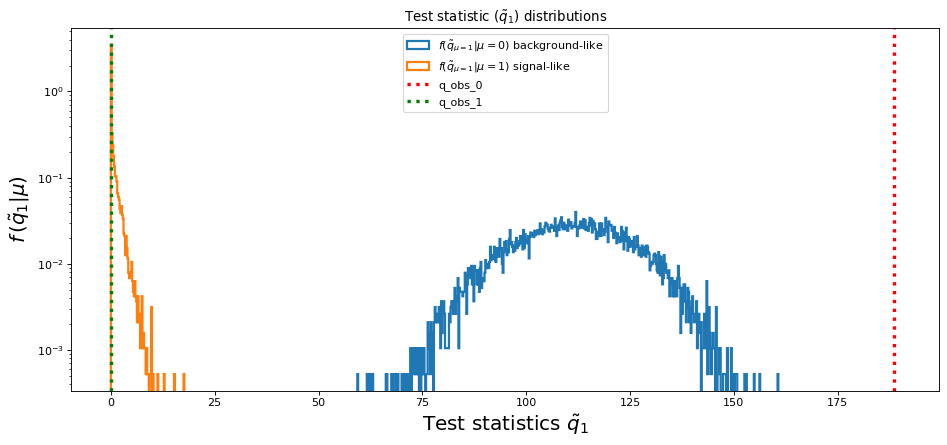

In [544]:
figure(figsize=(14, 6), dpi=80)
bins = np.linspace(0, 190, 1000)

histogram_0 = plt.hist(q_0_1s, 
                       bins = bins,
                       histtype = 'step',
                       facecolor='c', 
                       density=True,
                       label=r"$f(\tilde{q}_{\mu = 1}|\mu = 0)$ background-like",
                       linewidth=2)

histogram_1 = plt.hist(q_1_1s, 
                       bins = bins,
                       histtype = 'step',
                       facecolor='c',
                       density=True,
                       label =r"$f(\tilde{q}_{\mu = 1}|\mu = 1)$ signal-like",
                       linewidth=2)
                    
plt.axvline(q_obs_0, color='red',   linestyle='dotted', linewidth=3, label = "q_obs_0")
plt.axvline(q_obs_1, color='green', linestyle='dotted', linewidth=3, label = "q_obs_1")
plt.yscale('log')

plt.xlabel(r"Test statistics $\tilde{q}_1$", fontsize=18)
plt.ylabel(r"$f\,(\tilde{q}_1|\mu)$", fontsize=18)
plt.title(r"Test statistic $(\tilde{q}_1)$ distributions")
plt.legend()


### p-values

We define two p-values to be associated with the actual observation for the signal+background and background-only hypotheses, $p_{\mu}$ and $p_b$:

In [545]:
# retrieve counts and bins 
counts0, bins0, bars0 = histogram_0
counts1, bins1, bars1 = histogram_1
bin_width = bins0[1] - bins0[0]

# add a dummy count to have the
# same length for counts and bins
counts0 = np.append(counts0,0)
counts1 = np.append(counts1,0)

# H0
counts1_q = counts1[bins1>q_obs_1]
p_val_mu = sum( bin_width*counts1_q)
p_val_mu

counts0_q = counts0[bins0>q_obs_1]
p_val_b = sum( bin_width*counts0_q)

CL = p_val_mu/ p_val_b
#p_val_b
CL

0.33510000000000045

In [ ]:
# upper limit for mu: find the mu such that 0.5*q_mu = 1.35, 
# that would correspond to a one-sided CLs+b = 0.05 probability

In [511]:
def f(mu):
    return(q_tilde_mu(mu, mu_max,sim_signal_counts[0:,],sim_background_counts[0:,],true_counts[0:,]) - 1.35)

In [532]:
mu   = np.linspace(0, 1, 3001)
q_mu = []
for i in mu:
    x = f(i)
    q_mu.append(x)
mu_up = mu[q_mu.index(min(np.abs(q_mu)))]
print("mu upper limit: ", mu_up)

mu upper limit:  0.8236666666666667


The presence of the signal is quantified by the background-only p-value, i.e. the probability for the background to fluctuate and give an excess of events as large or larger than the observed one. As before, this requires defining a test statistic and the construction of its sampling distribution. For a given Higgs boson mass hypothesis mH, the test statistic used is q0


In [455]:
mu_s_0 = np.zeros(100000)
q_0_1s = np.zeros(100000)


for i in tqdm(range(100000)):
    toy_count0 = create_toy_distr(0,sim_signal_counts, sim_background_counts)
    
    fun0      = lambda mu: -log_likelihood(mu,
                                           sim_signal_counts,
                                           sim_background_counts,
                                           toy_count0)

    
    mu_opt_i_0  = sp.optimize.minimize(fun0,0.5,bounds=((0,1),))["x"]
    mu_s_0[i]   = mu_opt_i_0
    q_0_1s[i]   = q_tilde_mu(0, mu_s_0[i],
                       sim_signal_counts,
                       sim_background_counts,
                       toy_count0)


100%|█████████████████████████████████████████████████| 100000/100000 [18:57<00:00, 87.88it/s]


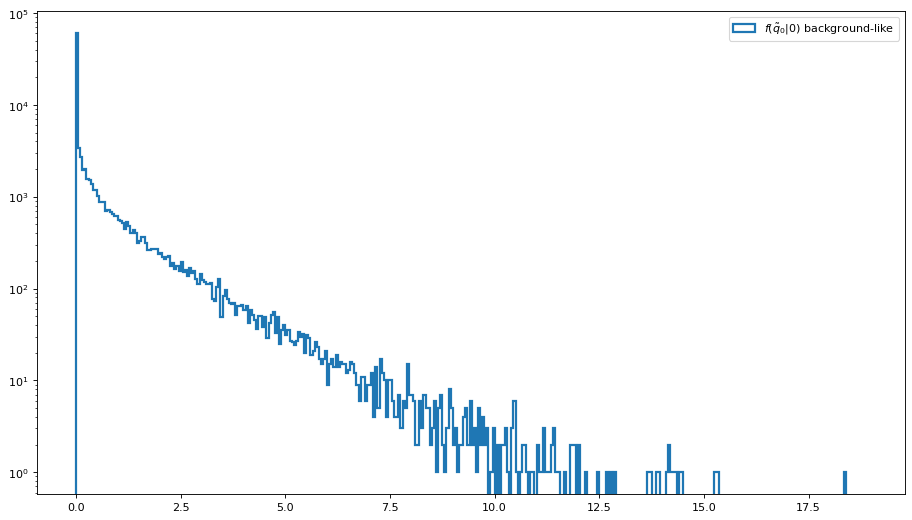

In [461]:
figure(figsize=(14, 8), dpi=80)
histogram_0 = plt.hist(q_0_1s, 
                       bins = np.arange(min(q_0_1s),max(q_0_1s) + 0.5,0.05),
                       histtype = 'step',
                       facecolor='c', 
                       #density=True,
                       label=r"$f(\tilde{q}_0|0)$ background-like",
                       linewidth=2)

#plt.axvline(q_obs_0, color='black', linestyle='dotted', linewidth=3, label = "q_obs_0")
plt.yscale('log')

plt.legend()

In [464]:
p_estimate = 0.5*(1 - special.erf(q_obs_0/2))
p_estimate

0.0

## Trying to further reduce the range

In [ ]:
# We have put in the line for q_obs_1, which is the q-funciton evaluated with mu_1 = 1 and mu_2 = best fit 
# We get that this is very low, much lower than in the cms-document. The value for q with the ratio of no signal vs. best fit
# is very high however, so we are not sure if that is correct. Also, our toy distributions for mu = 1 and mu = 0 do
# not overlap at all. Usually this would be the ideal case, but we were thinking we may have done something wrong as
# as we assumed they would be a bit more overlapping as in the CMS-case.

In [302]:
discard_bins = np.arange(5)

In [304]:
def q_mu_tilde_pdfs( signal    = sim_signal_counts, 
                     background = sim_background_counts, 
                     data      = true_counts,
                     i         = discard_bins[0]):
    
    model = pyhf.simplemodels.uncorrelated_background(
    [x for x in signal[i:,]], 
    [x for x in background[i:,]], 
    [x*0 for x in background[i:,]] # ignore nuisance parameter
    )
    
    data = pyhf.tensorlib.astensor( [x for x in data[i:,]] + model.config.auxdata)
    
    test_mu_b   = 0.0
    test_mu_s   = 1.0
    init_pars = model.config.suggested_init()

    par_bounds   = model.config.suggested_bounds()
    fixed_params = model.config.suggested_fixed()
    par_bounds[model.config.poi_index] = (0, 1)
    q0_obs = pyhf.infer.test_statistics.q0(test_mu_b, data, model, init_pars, par_bounds, fixed_params)
    q1_obs = pyhf.infer.test_statistics.qmu_tilde(test_mu_s, data, model, init_pars, par_bounds, fixed_params)
    
    output = {'q0_obs': q0_obs, 'q1_obs': q1_obs }
    
    
    # mu' = 0: background-like
    pars_bkg = model.config.suggested_init()
    pars_bkg[model.config.poi_index] = 0.0
    #print(f"Background parameters: {list(zip(model.config.parameters, pars_bkg))}")

    # mu' = 1: signal-like
    pars_sig = model.config.suggested_init()
    pars_sig[model.config.poi_index] = 1.0
    #print(f"Signal parameters: {list(zip(model.config.parameters, pars_sig))}")

    # make the pdfs
    pdf_bkg = model.make_pdf(pyhf.tensorlib.astensor(pars_bkg))
    pdf_sig = model.make_pdf(pyhf.tensorlib.astensor(pars_sig))
    
    n_samples = 10000

    # mu' = 0
    mc_bkg = pdf_bkg.sample((n_samples,))
    # mu' = 1
    mc_sig = pdf_sig.sample((n_samples,))
    
    toy_calculator_qtilde = pyhf.infer.utils.create_calculator(
    "toybased",
    model.expected_data(pars_sig),
    model,
    ntoys=n_samples,
    test_stat="qtilde",
    )
    
    qtilde_sig, qtilde_bkg = toy_calculator_qtilde.distributions(1.0)
    
    output['qtilde_sig'] = qtilde_sig
    output['qtilde_bkg'] = qtilde_bkg
    
    return output


In [425]:
x = []
for i in discard_bins:  
    x.append(q_mu_tilde_pdfs(i= i))

In [426]:
for i in range(len(x)):
    print('q0_obs:',x[i]['q0_obs'],'q1_obs:', x[i]['q1_obs'] )

q0_obs: 188.4600586158587 q1_obs: 0.12578050464998114
q0_obs: 188.29051118155274 q1_obs: 0.13300062291978065
q0_obs: 187.62942362879397 q1_obs: 0.16375532347342414
q0_obs: 187.45722999766588 q1_obs: 0.17093687619700404
q0_obs: 186.9020794034742 q1_obs: 0.19766663831859432


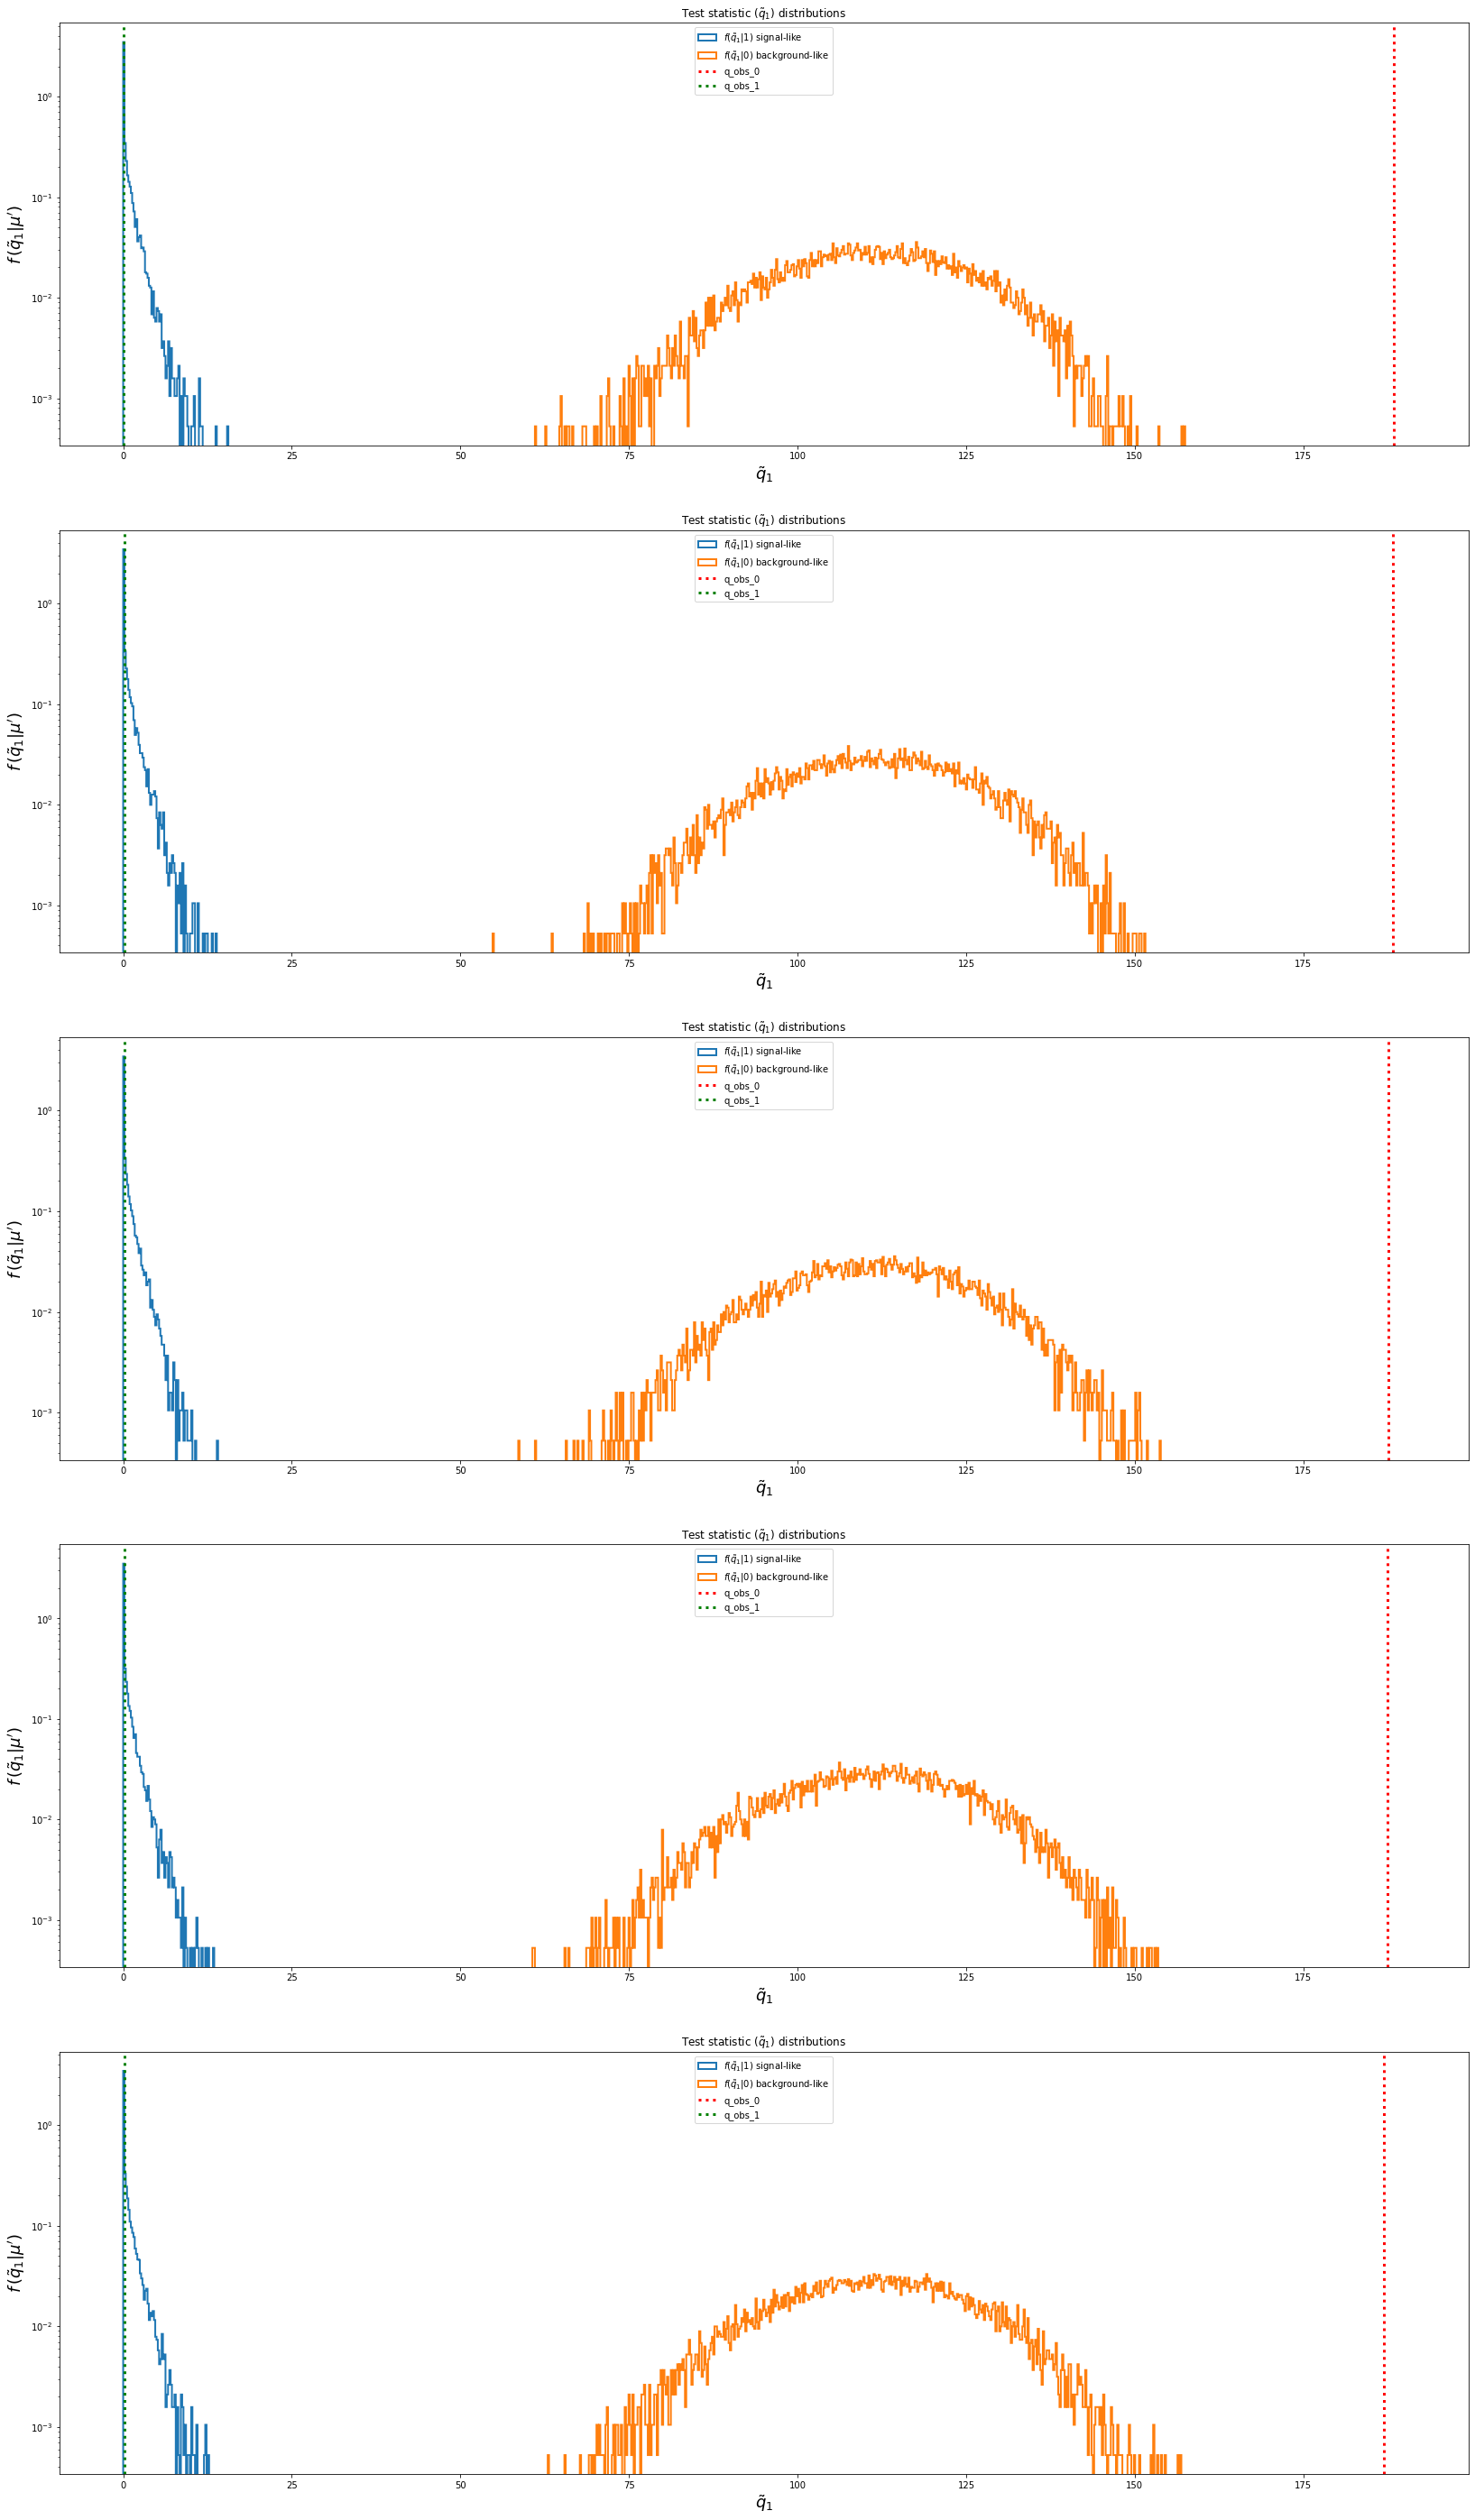

In [473]:
fig, ax = plt.subplots(5,1, figsize=(28,50))
CLs = []
p_val_bs = []

for i,ax in zip(range(len(x)), ax):

    bins = np.linspace(0, 190, 1000)

    hist1 = ax.hist(
        x[i]['qtilde_sig'].samples,
        bins=bins,
        histtype="step",
        density=True,
        label=r"$f(\tilde{q}_1|1)$ signal-like",
        linewidth=2,
    )
    hist0 = ax.hist(
    x[i]['qtilde_bkg'].samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|0)$ background-like",
    linewidth=2,
    )
    ax.axvline(x[i]['q0_obs'], color='red', linestyle='dotted', linewidth=3, label = "q_obs_0")
    ax.axvline(x[i]['q1_obs'], color='green', linestyle='dotted', linewidth=3, label = "q_obs_1")
    ax.set_xlabel(r"$\tilde{q}_1$", fontsize=18)
    ax.set_ylabel(r"$f\,(\tilde{q}_1|\mu')$", fontsize=18)
    ax.set_title(r"Test statistic $(\tilde{q}_1)$ distributions")
    ax.legend()
    ax.set_yscale('log')

    counts0, bins0, bars0 = hist0
    counts1, bins1, bars  = hist1
    
    bin_width = bins0[1] - bins0[0]

    counts1_q = counts1[bins1[:-1]>x[i]['q1_obs']]
    p_val_mu  = sum( bin_width*counts1_q)
    

    counts0_q = counts0[bins0[:-1]>x[i]['q1_obs']]
    p_val_b   = sum( bin_width*counts0_q)
    p_val_bs.append(p_val_b)
    CL = p_val_mu/ p_val_b
    CLs.append(CL)
   

In [474]:
p_val_bs

[0.9999999999999987,
 0.9999999999999993,
 0.999999999999999,
 0.9999999999999984,
 0.9999999999999988]

In [476]:
CLs

[0.3373000000000004,
 0.3409000000000001,
 0.3435000000000003,
 0.33190000000000036,
 0.2784000000000003]